In [1]:
# Entities
import numpy as np
import torch

from processing.RL.DDPG.ddpg import DDPG
from processing.robotics.arm_propagator import ArmPropagator, ElectromagnetEndEffector, RevoluteJoint
from processing.system_animation import animate_system
from processing.utilities.entities import Cylinder

# Attitude
from processing.attitude.attitude_propagator import AttitudePropagator
from processing.attitude.torques.base import TorqueObject
from processing.attitude.torques.eddy_current import EddyCurrentTorque

# Environment
from propagator.bin.environment import Environment

# System setup

In [2]:
# Generate debris
debris = Cylinder(
    mass=950.0,
    radius=2.5,
    height=5.0,
    thickness=0.1,
    sigma=35000000.0
)

# Generate robotic arms (UR10 standard)
# Joints
joints = [
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(0, 0.25, -np.pi/2),
    RevoluteJoint(0, 0.25, 0)
]

# CoM
com = [
    [0, -joints[0].d/2, 0],
    [joints[1].a/2, 0, 0],
    [joints[2].a/2, 0, 0],
    [0, -joints[3].d/2, 0],
    [0, joints[4].d/2, 0],
    [0, 0, -joints[5].d/2]
]

# End effector
electromagnet: ElectromagnetEndEffector = ElectromagnetEndEffector(
    n_turns=500.0,
    radius=1.0,
    current=50.0
)

# External moments
# Eddy current
eddy: TorqueObject = EddyCurrentTorque(
    entity=debris,
    chaser_w0=[0.0, 0.0, 0.0],
    electromagnets=[electromagnet]
)

# Save attitude results
attitude = AttitudePropagator(entity=debris, M_ext=eddy)

# Save robotic arm results
base_offset = np.array([10, 0, 5])
max_torques = np.array([.025, .025, .025, .025, .025, .025])
arm = ArmPropagator(joints=joints, com=com, end_effector=electromagnet, base_offset=base_offset, max_torques=max_torques)

# Environment Setup

In [3]:
# Set propagation settings
t_step = .1  # Propagation time step [s]

# Set initial conditions
y0_arm = [
    0, 0.7, 0.3, 0.0, 0.0, 0.0,   # Initial joint angles
    0.02, 0.0, 0.0, 0.0, 0.0, 0.0   # Initial joint velocities
]

y0_debris = [
    0.1, 0.2, 0.0,                    # Initial debris angular velocity
    0.0, 0.0, 0.0, 1.0                # Initial debris quaternions
]

# Initialize environment
env = Environment(
    y0_arm + y0_debris,                   # Initial conditions
    debris.Ixx,                           # Debris Ixx
    debris.Iyy,                           # Debris Iyy
    debris.Izz,                           # Debris Izz
    debris.radius,                        # Debris cylinder radius
    debris.height,                        # Debris cylinder height 
    debris.thickness,                     # Debris cylinder thickness
    debris.sigma,                         # Debris conductivity
    electromagnet.n_turns,                # Coil number of turns
    electromagnet.current,                # Coil current
    electromagnet.radius,                 # Coil radius
    arm.base_offset_x,                    # Arm base x-offset
    arm.base_offset_y,                    # Arm base y-offset
    arm.base_offset_z,                    # Arm base z-offset
    arm.dh_a,                             # Arm joint a parameters
    arm.dh_d,                             # Arm joint d parameters
    arm.dh_alpha,                         # Arm joint alpha parameters
    arm.max_torques,                      # Arm joint max torques
    arm.com                               # Arm link CoMs
    )

## Define save function

In [4]:
def save(tf, prop):
    # to numpy
    prop = np.array(prop)
    
    # save
    arm.save_new(tf, prop=prop)
    attitude.save_new(tf, prop=prop)
    
# Get initial state
t, s = env.current_state()
save(t, s)

# DDPG: Training

Define stopping criteria: collision or completed detumbling

In [5]:
# Define safe sphere for collision check
safe_sphere: float = max(debris.height/2, debris.radius) + 0.5  # [m]

# Define detumbling threshold
detumbling_threshold: float = 0.01  # [rad/s]

Define reward and end checks function

In [6]:
def evaluate_step(step_ret, prev_state):
    # Convert to numpy
    step_ret = np.array(step_ret)
    state = np.array([*step_ret[:15], *step_ret[19:25]])
    
    # Init "done" and "reward"
    done = 0  # "done" normally negative
    reward = 0
    
    # Check: collision with safe sphere
    for i in range(len(arm.joints) + 1):
        pos: np.ndarray = arm.get_joint_position(step_ret[0:6], i)
        if np.linalg.norm(pos) <= safe_sphere:
            reward -= 10
            
    # Check: tumbling rates below certain threshold
    ang_vels: np.ndarray = step_ret[12:15]
    if np.all(np.abs(ang_vels) <= detumbling_threshold):
        done = 1
        # reward += 25
        print("Detumbling", reward)
        return state, reward, done  # Detumbling completed, simulation over
    
    # Penalty: end effector pointing away
    ee_loc: np.ndarray = -step_ret[19:22]
    ee_pos: np.ndarray = step_ret[22:25]
    angle = np.arccos(np.dot(ee_loc / np.linalg.norm(ee_loc), ee_pos / np.linalg.norm(ee_pos)))
    reward -= abs(angle)
    
    """# Check: joint angles beyond a certain threshold
    if np.any(np.abs(step_ret[6:12]) > max_joint_vel):
        reward -= 5
        return state, reward, done  # Joint angular velocity too high, simulation over"""
    
    """# Check: range beyond a certain value
    if np.any(np.abs(step_ret[:6]) > max_range):
        reward -= 5
        return step_ret, reward, done  # Joint max range too high, simulation over

    # Reward: Detumbling rate
    dwx = abs(step_ret[12]) - abs(prev_state[12]) / t_step
    dwy = abs(step_ret[13]) - abs(prev_state[13]) / t_step
    dwz = abs(step_ret[14]) - abs(prev_state[14]) / t_step
    
    if sum(1 for grad in [dwx, dwy, dwz] if grad < 0) < 2:
        reward -= 0.25  # no component decreasing
    """
    
    return state, reward, done

## Train setup

In [7]:
# Init torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent
max_episode = 50
max_time_steps = 500
ep_r = 0
total_step = 0
score_hist = []

# For reproducibility
# env.seed(0)
# torch.manual_seed(0)
# np.random.seed(0)

# Environment action and states
state_dim = 3+3
action_dim = 3
min_Val = torch.tensor(1e-7).float().to(device)

# Create a DDPG instance
agent = DDPG(state_dim, action_dim, hidden_actor=256, hidden_critic=256)

## Training loop

In [8]:
# Train the agent for max_episodes
for i in range(max_episode):
    total_reward = 0
    step = 0

    # Reset environment
    state = np.array(env.current_state()[-1])[:state_dim]  # discard time
    for _ in range(max_time_steps):
        # Get action
        noise = max_range * np.random.normal(0, 1, size=action_dim)
        action = (agent.select_action(state) + noise).clip(-max_range, max_range) # Noise and clip
        # action += ou_noise.sample()
        
        # Set control parameters
        env.set_control_torque(yD=list(action) + [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        # Perform step
        t, step_ret = env.step(t_step=t_step)
        next_state, reward, done = evaluate_step(step_ret, state)

        # Retrieve reward
        total_reward += reward
        agent.replay_buffer.push((state, next_state, action, reward, done))
        state = next_state
        if done:
            break
        step += 1
        
    del env
    env = Environment(
    y0_arm + y0_debris,                   # Initial conditions
    debris.Ixx,                           # Debris Ixx
    debris.Iyy,                           # Debris Iyy
    debris.Izz,                           # Debris Izz
    debris.radius,                        # Debris cylinder radius
    debris.height,                        # Debris cylinder height 
    debris.thickness,                     # Debris cylinder thickness
    debris.sigma,                         # Debris conductivity
    electromagnet.n_turns,                # Coil number of turns
    electromagnet.current,                # Coil current
    electromagnet.radius,                 # Coil radius
    arm.base_offset_x,                    # Arm base x-offset
    arm.base_offset_y,                    # Arm base y-offset
    arm.base_offset_z,                    # Arm base z-offset
    arm.dh_a,                             # Arm joint a parameters
    arm.dh_d,                             # Arm joint d parameters
    arm.dh_alpha,                         # Arm joint alpha parameters
    arm.max_torques                       # Arm joint max torques
    )

    score_hist.append(total_reward)
    total_step += step + 1
    print("\nEpisode: {} \t Time: {:0.2f}s \t Total Reward: {:0.2f}".format(i, t, total_reward))
    agent.update(update_iteration=200, gamma=0.99, tau=0.001, batch_size=32)
    if i % 10 == 0:
        agent.save("./")

At (0) t = 1.0000e-01    y =  2.129448e+00    8.724814e-01    5.237022e-01   -2.499062e-04   -1.127568e-05    2.499062e-04    3.519778e-01
At (1) t = 2.0000e-01    y =  2.164790e+00    8.719320e-01    5.240123e-01   -9.992503e-04   -4.508581e-05    9.992503e-04    3.548586e-01
At (2) t = 3.0000e-01    y =  2.200418e+00    8.710169e-01    5.245288e-01   -2.247470e-03   -1.014050e-04    2.247470e-03    3.577085e-01
At (3) t = 4.0000e-01    y =  2.236330e+00    8.697364e-01    5.252515e-01   -3.994004e-03   -1.802080e-04    3.994004e-03    3.605273e-01
At (4) t = 5.0000e-01    y =  2.272376e+00    8.681905e-01    5.262609e-01   -5.931577e-03   -1.135861e-04    5.975225e-03    3.596484e-01
At (5) t = 6.0000e-01    y =  2.308160e+00    8.664905e-01    5.275019e-01   -7.453987e-03    2.193658e-04    7.823947e-03    3.553395e-01
At (6) t = 7.0000e-01    y =  2.343620e+00    8.644527e-01    5.285483e-01   -8.804175e-03    2.617855e-04    1.003181e-02    3.553822e-01
At (7) t = 8.0000e-01    y 

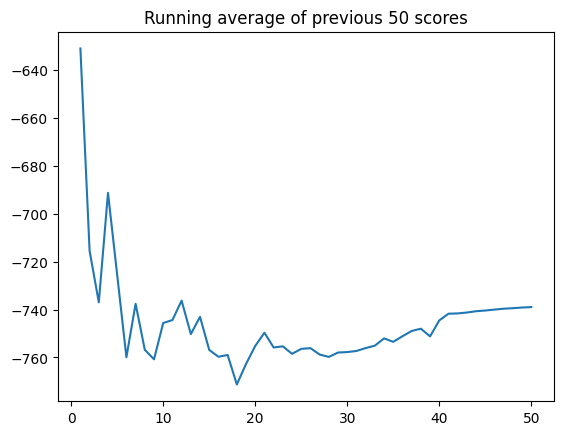

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title(f'Running average of previous {max_episode} scores')

x = [i+1 for i in range(len(score_hist))]
plot_learning_curve(x, score_hist)

# DDPG: Testing

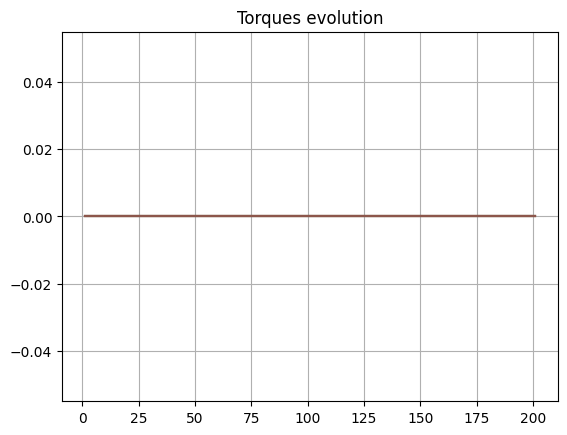

In [11]:
x = [i+1 for i in range(arm.joint_torques.shape[-1])]
plt.title(f'Torques evolution')
plt.grid(True)
plt.plot(x, arm.joint_torques.T)

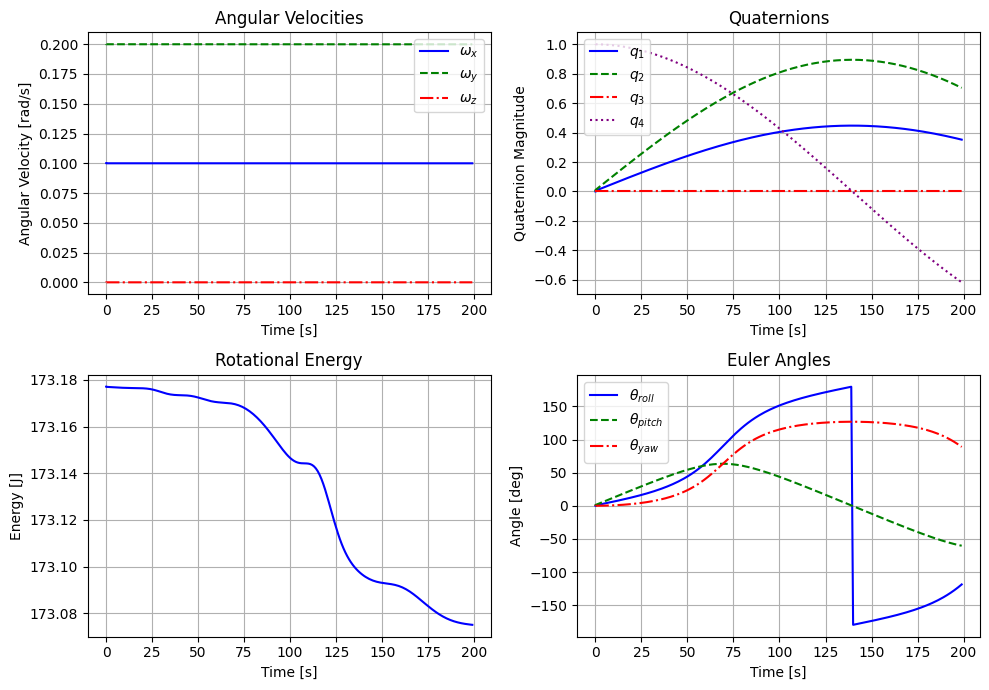

In [12]:
attitude.plot(["angular_velocity", "quaternions", "energy", "euler_angles"])

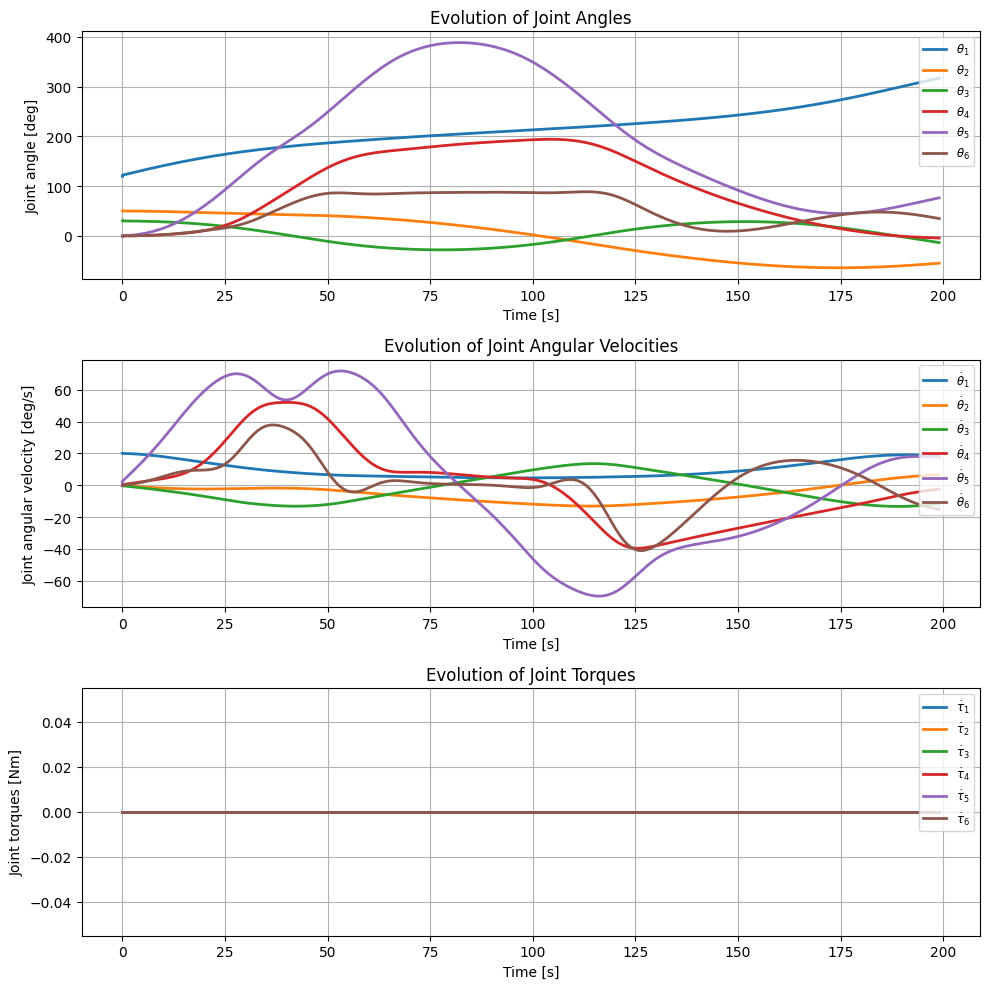

In [13]:
arm.plot()

- Animation rendering progress -
[=====================]  100.00% (201/201) ETA: 0m 0s


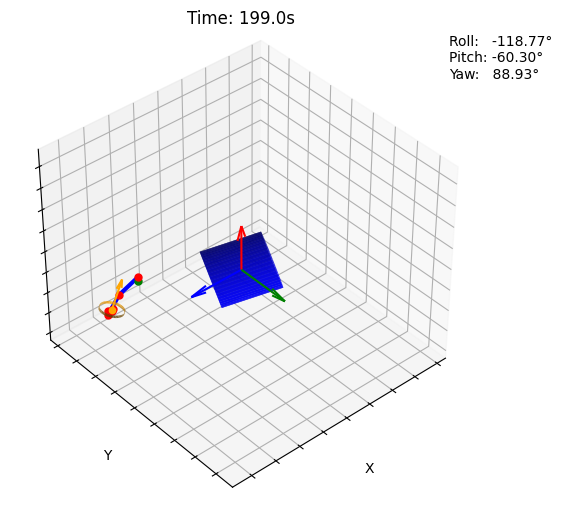

In [14]:
animate_system(
    t=attitude.t,
    q=attitude.q,
    eu=attitude.euler_angles,
    h=debris.height,
    r=debris.radius,
    dpi=300,
    arms=[arm],
    dh_par=joints
)